# Research on Apartment Sale Listings

You have access to data from the Yandex.Real Estate service, which includes an archive of apartment sale listings in St. Petersburg and nearby localities over several years. The goal is to learn how to determine the market value of real estate properties. The task is to establish parameters. This will allow the development of an automated system: it will monitor anomalies and fraudulent activities.

For each apartment for sale, two types of data are available. The first type is entered by the user, and the second is obtained automatically based on cartographic data. For example, the distance to the city center, the airport, the nearest park, and bodies of water.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('future.no_silent_downcasting', True)

## Data loading

In [3]:
data = pd.read_csv('../datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


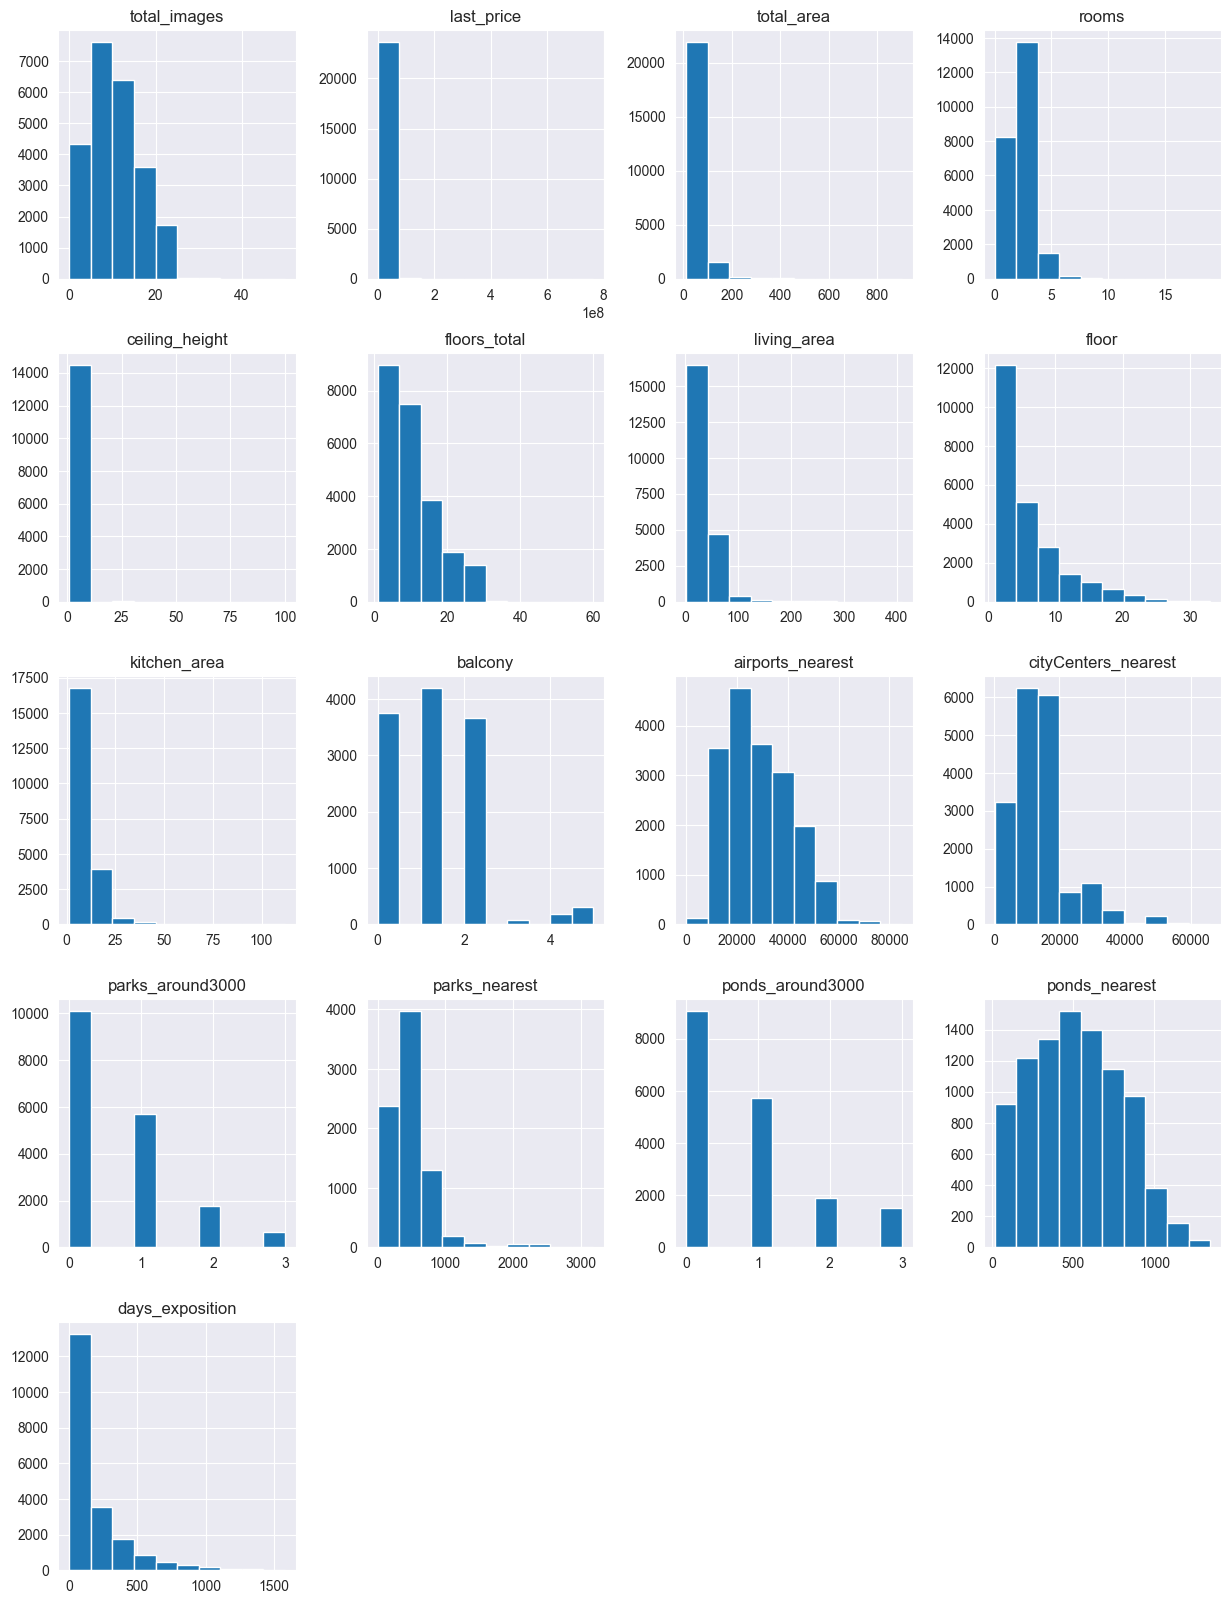

In [4]:
data.hist(figsize=(15, 20));

In [5]:
data['locality_name'].value_counts()

locality_name
Санкт-Петербург                    15721
посёлок Мурино                       522
посёлок Шушары                       440
Всеволожск                           398
Пушкин                               369
                                   ...  
поселок Каложицы                       1
посёлок Платформа 69-й километр        1
поселок Почап                          1
поселок Гончарово                      1
посёлок Дзержинского                   1
Name: count, Length: 364, dtype: int64

We see that almost 16,000 listings are placed in St. Petersburg. In total, there are 364 different localities (before removing duplicates).

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

The dataframe contains a total of 23,699 entries. Based on the output of the `data.info()` function, we can identify the attributes that contain missing values. These attributes are: `ceiling_height`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, and `days_exposition`.

Categorical attributes:
- `rooms`
- `floor`
- `is_apartment`
- `studio`
- `open_plan`
- `balcony`
- `locality_name`
- `parks_around3000`
- `ponds_around3000`

Numerical attributes:
- `total_images`
- `last_price`
- `total_area`
- `ceiling_height`
- `floors_total`
- `living_area`
- `kitchen_area`
- `airports_nearest`
- `cityCenters_nearest`
- `parks_nearest`
- `ponds_nearest`
- `days_exposition`

The `first_day_exposition` attribute will need to be converted to a standard date format.

## Data preprocessing

### Missing values, data cleaning

In [7]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,38.800000
floors_total,0.400000
living_area,8.000000
floor,0.000000
is_apartment,88.300000


Overall, there are a significant number of missing values in the dataset.

It's likely that in categorical attributes where the value can be zero, the data was not entered. For example, `balcony`, `parks_around3000`, and `ponds_around3000`.

The `is_apartment` attribute is boolean. Here, the absence of a value can be considered as 0 or False.

For attributes related to area, missing values may appear where it was not clearly defined how to calculate the area. For instance, in studio-type apartments, the kitchen is combined with the living area, so the kitchen area may be 0. Missing values in `living_area` could appear if the space is not defined as a living area. Since there are no missing values in the `total_area` attribute, we can assume that there are some properties where either `kitchen_area = 0`, `living_area = 0`, or both are 0.

Since there are missing values in attributes that were determined automatically, it is worth clarifying if the search radius was somehow limited. If no objects were found within a certain radius, then there is no distance to the nearest one. Based on the attribute names, it seems that the search for ponds and parks was conducted within a radius of 3000 meters. For airports and the city center, the radius differed. Filling in the missing values with 0 would be incorrect, as such objects could be perceived as hotels located on airport grounds or houses next to a pond/park. Therefore, we'll leave the values as NaN.

The absence of values in `ceiling_height` could be due to human error. We can fill in the missing values with the median attribute value. Similarly, with the `floors_total` attribute, there are far fewer missing values. Perhaps some sellers considered it unnecessary to specify the number of floors if, for example, all the apartments in the house are on one floor. These gaps can be filled with the value 1.

There are only 49 missing values in `locality_name`. Based on the available data, we cannot definitively determine where the property is located. Therefore, it's better to delete the rows with missing values in this attribute.

There are also missing values in `days_exposition`. Perhaps these properties have not yet been sold or were removed from the sale without updating the information. We'll leave the values as NaN.

In [8]:
data = data.dropna(subset=['locality_name'])

In [9]:
data[['balcony', 'living_area', 'kitchen_area']] = \
    data[['balcony', 'living_area', 'kitchen_area']].fillna(0)

data = data.fillna(value={
    'ceiling_height': data['ceiling_height'].median(),
    'floors_total': 1,
    'is_apartment': False
})

In [10]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


### Data transformation

In [11]:
data[['last_price', 'total_area', 'floors_total', 'balcony']] = \
data[['last_price', 'total_area', 'floors_total', 'balcony']].astype('int')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],
format='%Y-%m-%dT%H:%M:%S')

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000,40,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000,159,2015-07-24,3,2.65,14,0.0,9,False,...,0.0,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  int64         
 2   total_area            23650 non-null  int64         
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  object        
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony              

The attributes 'last_price', 'floors_total', and 'balcony' were changed from float to int to eliminate the decimal point, as these attributes cannot have fractional values.

The 'first_day_exposition' day is now correctly displayed in datetime format instead of object, allowing for the use of built-in functions.

Since the attributes 'days_exposition', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest', 'parks_around3000', and 'ponds_around3000' have NaN values, their data type is left as float (since conversion of NaN is not supported), even though precision to the meter is not as important here.

### Duplicates

In [13]:
data['locality_name'].nunique()

364

In [14]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [15]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['городской посeлок', 'поселок городского типа', 'коттеджный поселок',
              'поселок при железнодорожной станции' ], 'поселок', regex=True)
)

In [16]:
data['locality_name'].nunique()

328

In [17]:
data.duplicated().sum()

0

In [18]:
data.shape

(23650, 22)

## New attributes

- The price per square meter (divide the cost of the property by its total area and then round to two decimal places).
- The day of the week the listing was published (0 — Monday, 1 — Tuesday, and so on).
- The month the listing was published.
- The year the listing was published.
- The type of floor the apartment is on (values: "first", "last", "other").
- The distance to the city center in kilometers (convert from meters to kilometers and round to the nearest whole number).

In [19]:
def get_floor_category(row):
    if row['floor'] == 1:
        return '1st'
    elif row['floor'] == row['floors_total']:
        return 'top'
    else:
        return 'other'

In [20]:
def get_weekday(row):
    if row['first_day_exposition'].weekday() == 0:
        return 'MON'
    elif row['first_day_exposition'].weekday() == 1:
        return 'TU'
    elif row['first_day_exposition'].weekday() == 2:
        return 'WED'
    elif row['first_day_exposition'].weekday() == 3:
        return 'THU'
    elif row['first_day_exposition'].weekday() == 4:
        return 'FRI'
    elif row['first_day_exposition'].weekday() == 5:
        return 'SAT'
    elif row['first_day_exposition'].weekday() == 6:
        return 'SUN'
    return None


In [21]:
data['m2_price'] = round(data['last_price'] / data['total_area'], 2)
data['floor_category'] = data.apply(get_floor_category, axis=1)
data['weekday'] = data.apply(get_weekday, axis=1)
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data['center_distance'] = round(data['cityCenters_nearest'] / 1000)

In [22]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m2_price,floor_category,weekday,month,year,center_distance
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,other,THU,3,2019,16.0
1,7,3350000,40,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0.0,NaN,81.0,83750.00,1st,TU,12,2018,19.0
2,10,5196000,56,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,other,THU,8,2015,14.0
3,0,64900000,159,2015-07-24,3,2.65,14,0.0,9,False,...,84.0,3.0,234.0,424.0,408176.10,other,FRI,7,2015,7.0
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,other,TU,6,2018,8.0


## Exploratory Data Analysis

### Diagrams

In [23]:
columns_list = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
                'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
               'ponds_around3000', 'ponds_nearest', 'm2_price', 'center_distance']

cat_list =  ['rooms', 'floors_total', 'floor', 'parks_around3000', 'ponds_around3000',
              'floor_category', 'weekday', 'month', 'year']

num_list = ['last_price', 'total_area', 'ceiling_height', 'living_area', 'kitchen_area', 'airports_nearest',
            'cityCenters_nearest', 'parks_nearest', 'ponds_nearest', 'm2_price', 'center_distance']

In [24]:
data[columns_list].describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,m2_price,center_distance
count,2.365000e+04,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,23650.000000,18116.000000,18139.000000,18140.000000,8064.000000,18140.000000,9085.000000,2.365000e+04,18139.000000
mean,6.541127e+06,60.100930,2.070106,2.724311,10.641099,31.683748,5.893277,9.552654,28803.225878,14197.860742,0.611577,490.830729,0.769680,518.059879,9.988496e+04,14.191576
std,1.089640e+07,35.673519,1.078620,0.989255,6.608379,23.114453,4.883317,6.416640,12637.314144,8606.830295,0.802003,342.554386,0.937948,277.841733,5.044967e+04,8.614645
min,1.219000e+04,12.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.118300e+02,0.000000
25%,3.400000e+06,40.000000,1.000000,2.600000,5.000000,17.800000,2.000000,6.300000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,7.700000e+04,9.000000
50%,4.650000e+06,52.000000,2.000000,2.650000,9.000000,29.000000,4.000000,9.000000,26756.500000,13105.000000,0.000000,454.500000,1.000000,502.000000,9.545455e+04,13.000000
75%,6.799000e+06,69.000000,3.000000,2.700000,16.000000,41.037500,8.000000,11.427500,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,1.148953e+05,16.000000
max,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1.907500e+06,66.000000


In [25]:
def plot_num_data(df, num_list):
    sns.set(style="whitegrid")

    for attr in num_list:
        # Boxplot
        plt.figure(figsize=(4, 5))
        sns.boxplot(y=attr, data=df, color="skyblue")
        plt.title(f"Boxplot for {attr}", fontsize=14)
        plt.xlabel(attr, fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Histogram
        plt.figure(figsize=(8, 5))
        ax = sns.histplot(df[attr], kde=True, color='skyblue', bins=15)
        ax.set_title(f"Histogram for {attr}", fontsize=14)
        ax.set_xlabel(attr, fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)

        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

        plt.tight_layout()
        plt.show()


def plot_cat_data(df, cat_list):
    sns.set(style="whitegrid")

    for attr in cat_list:
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x=attr, data=df, hue=attr, palette="muted", legend=False)
        ax.set_title(f"Bar Chart for {attr}", fontsize=14)
        ax.set_xlabel(attr, fontsize=12)
        ax.set_ylabel("Count", fontsize=12)

        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 1), textcoords='offset points', rotation=45)

        plt.tight_layout()
        plt.show()

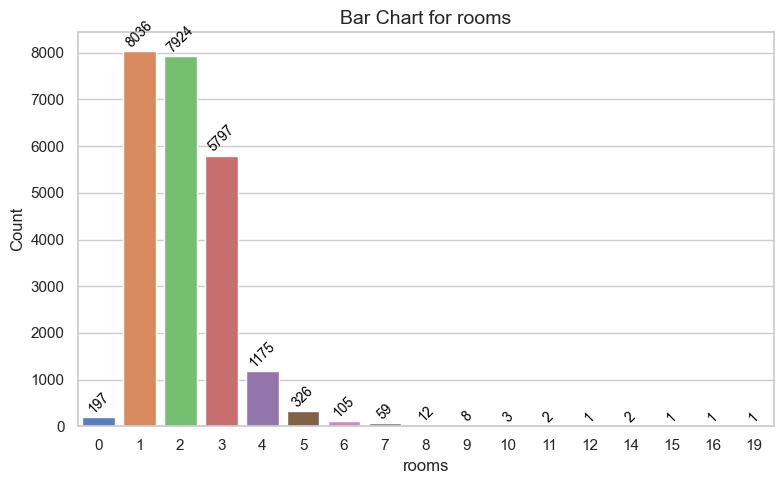

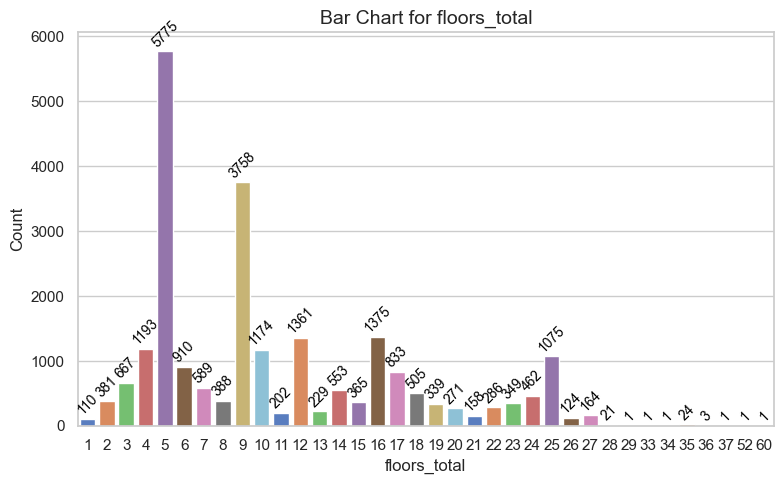

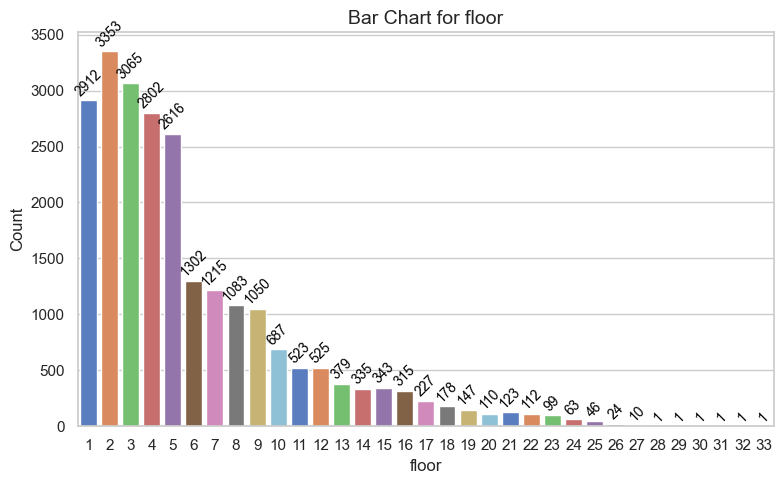

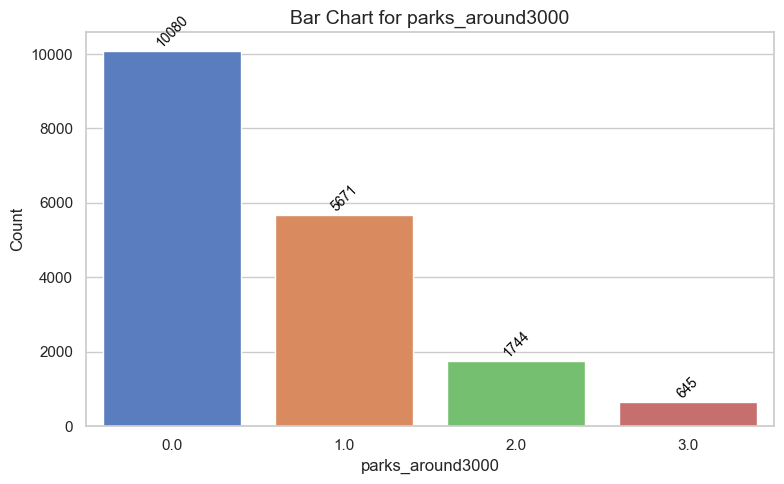

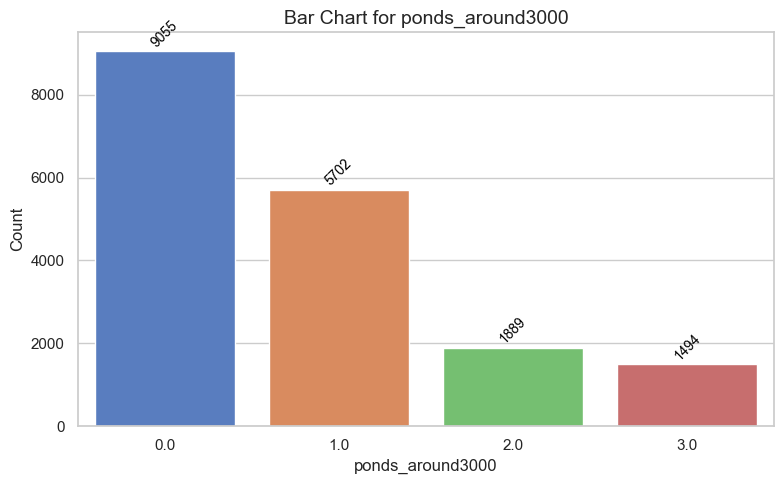

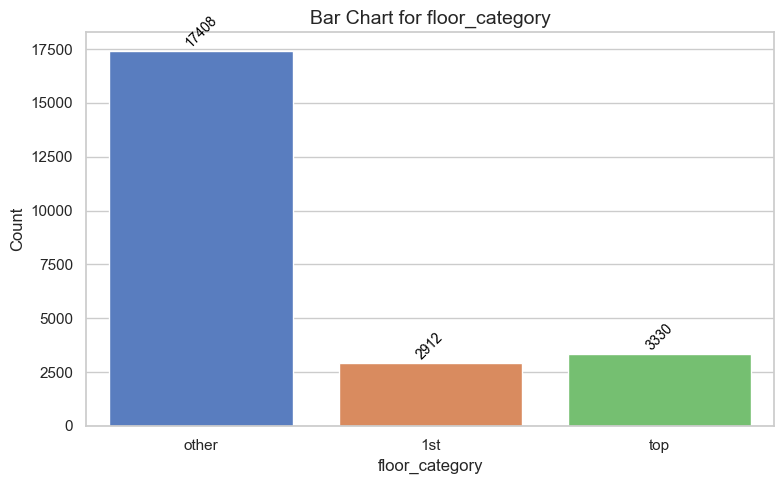

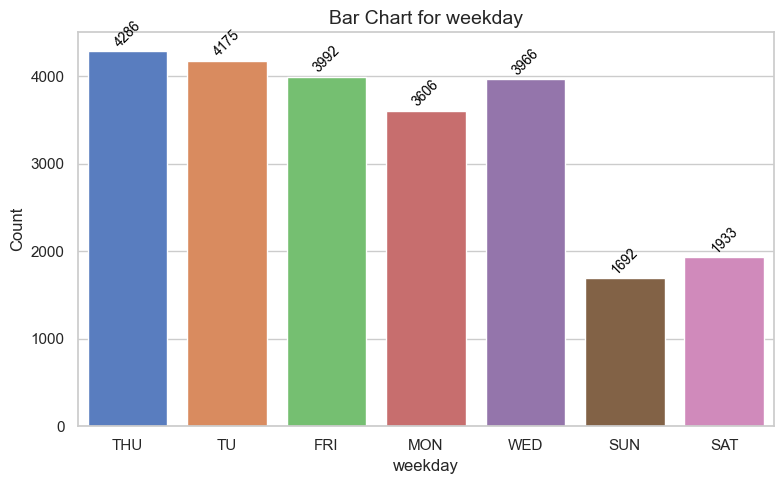

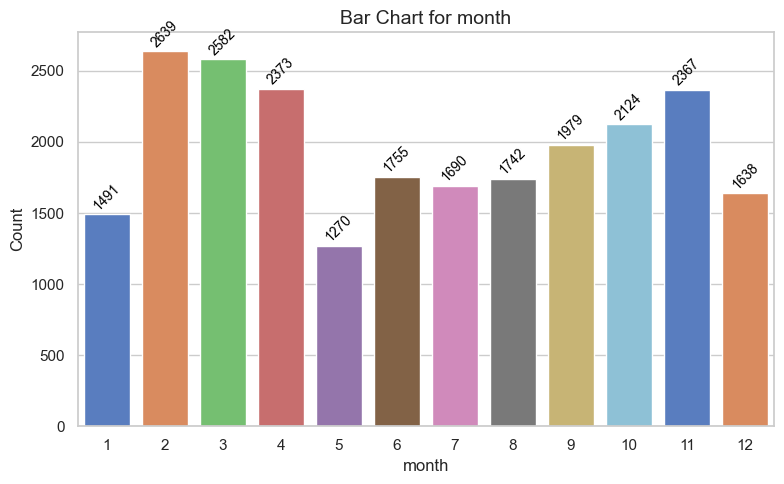

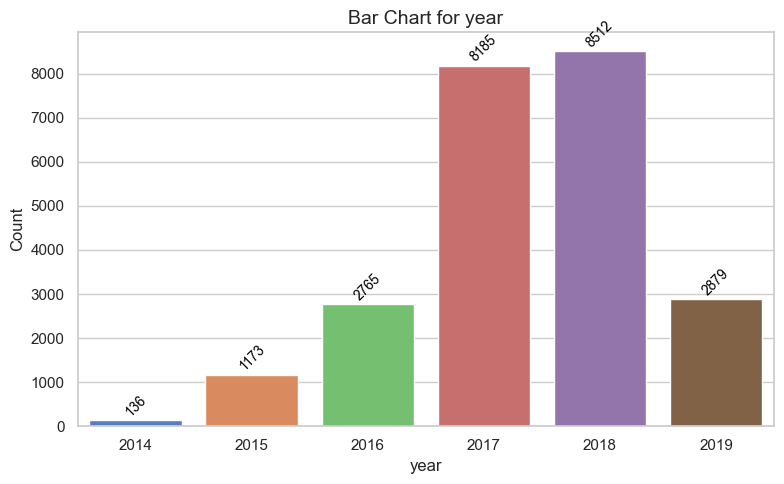

In [26]:
plot_cat_data(data, cat_list)

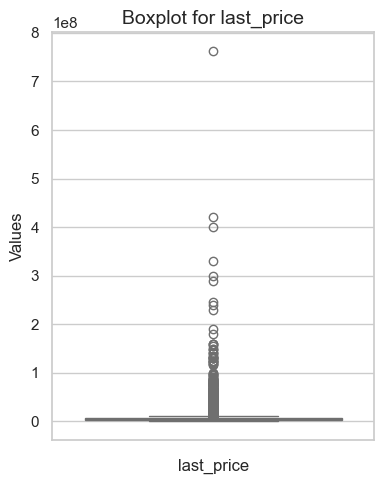

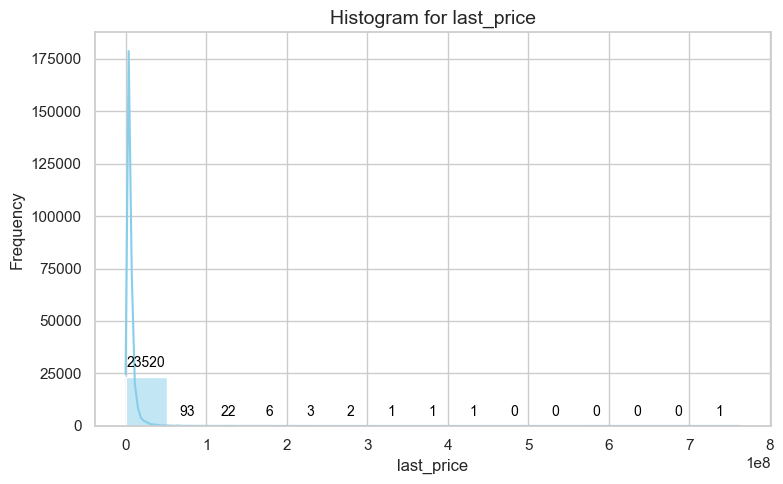

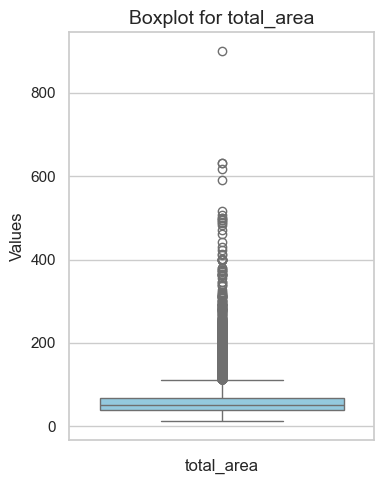

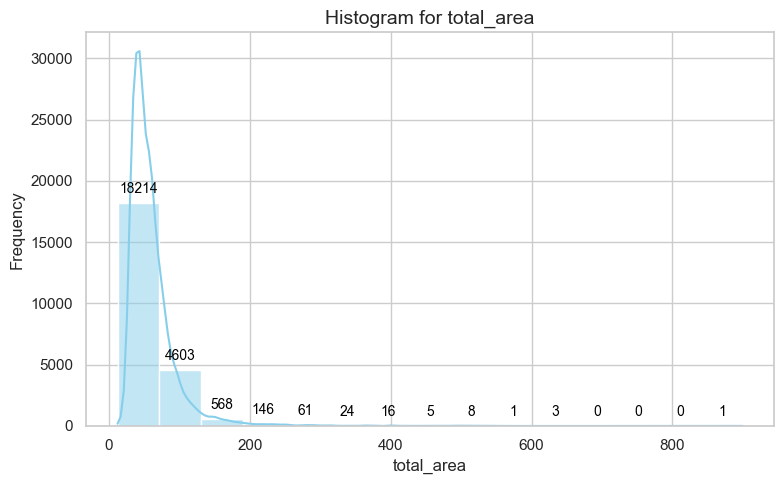

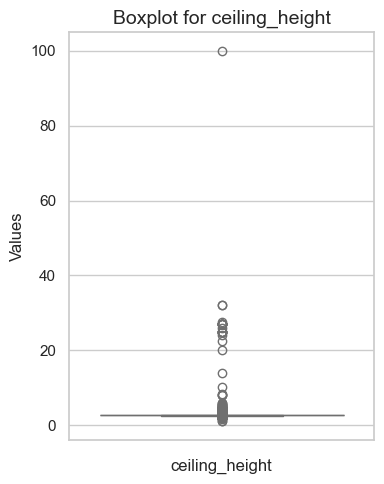

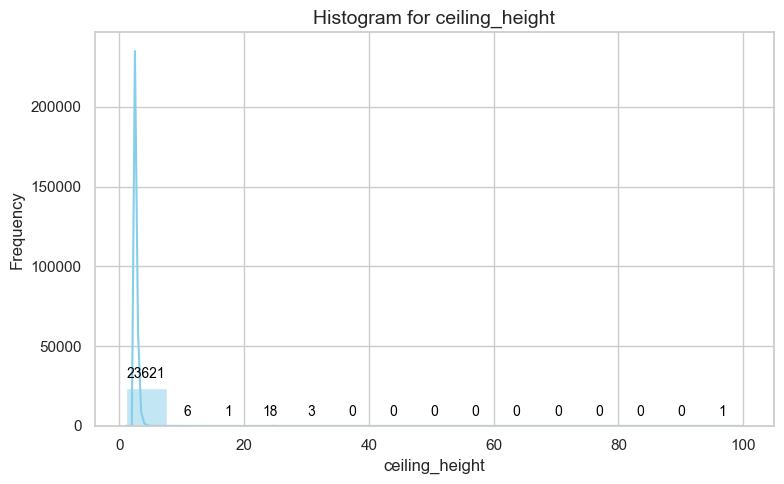

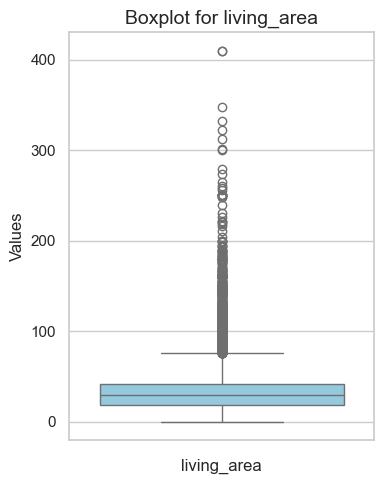

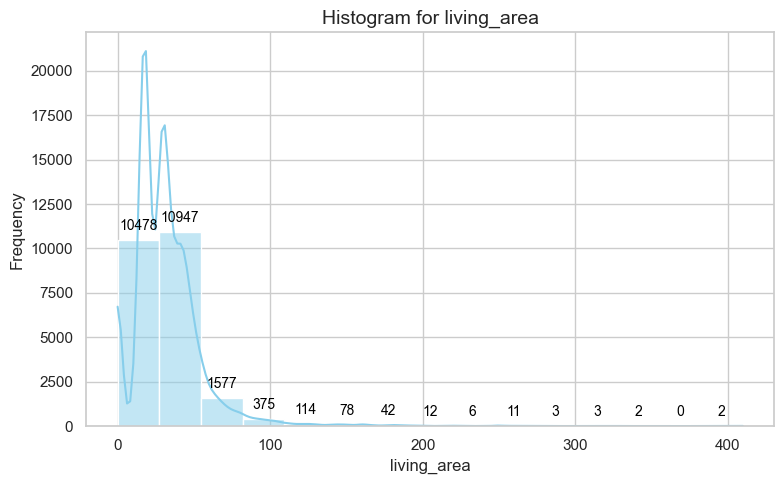

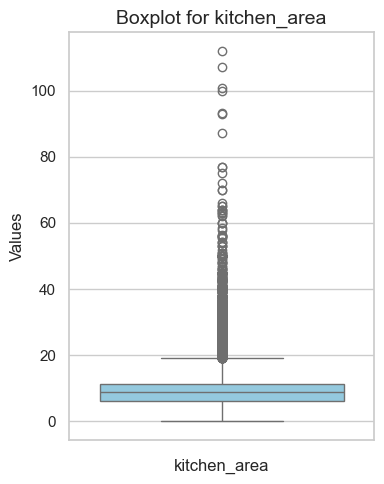

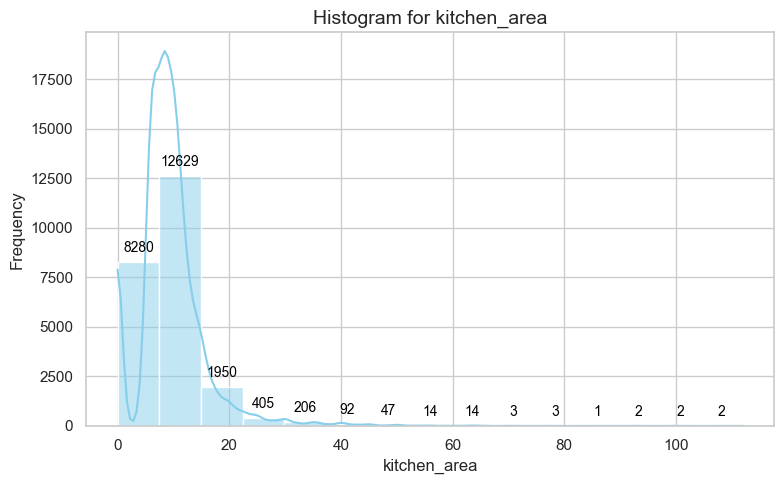

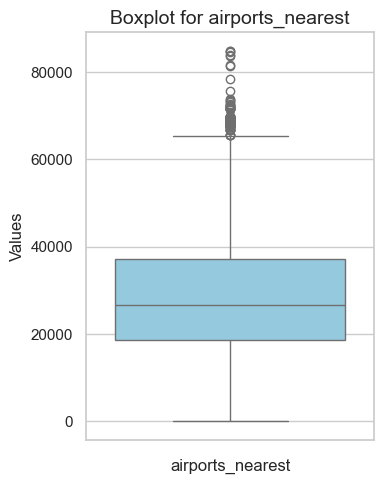

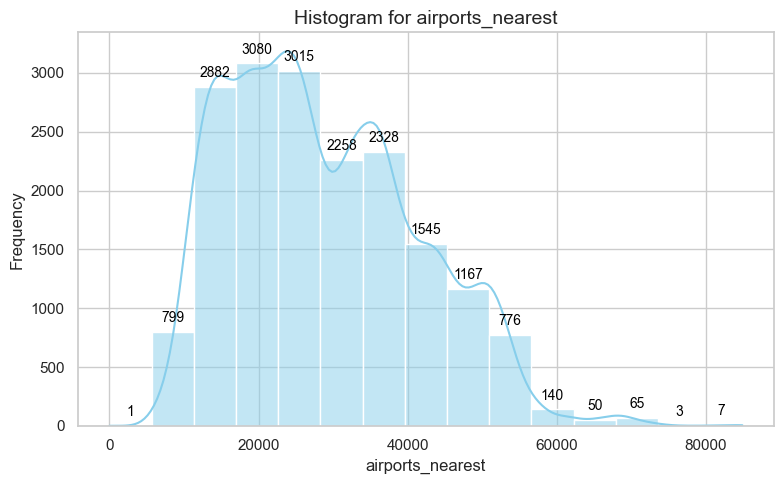

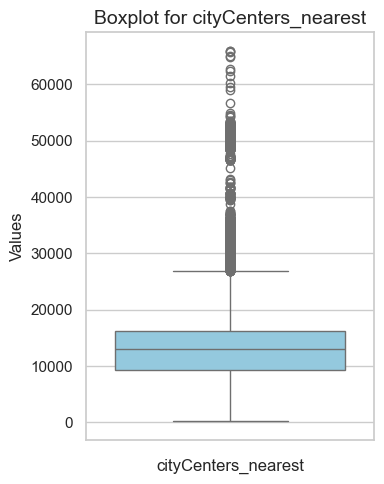

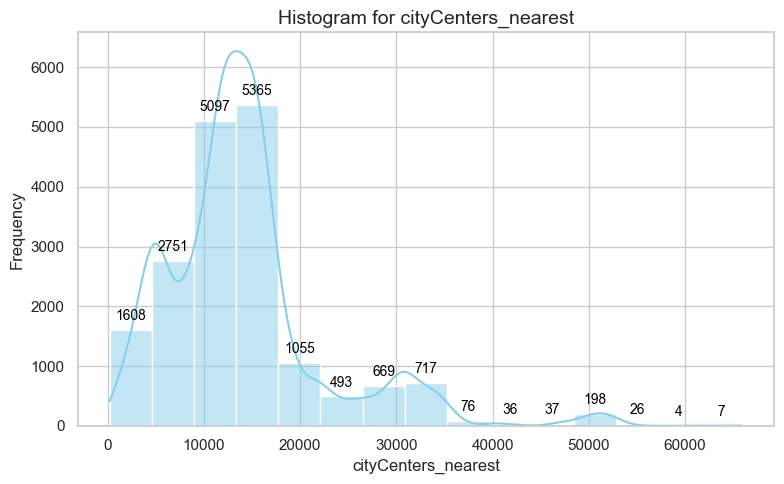

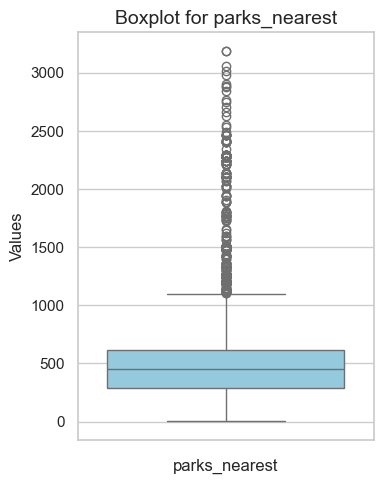

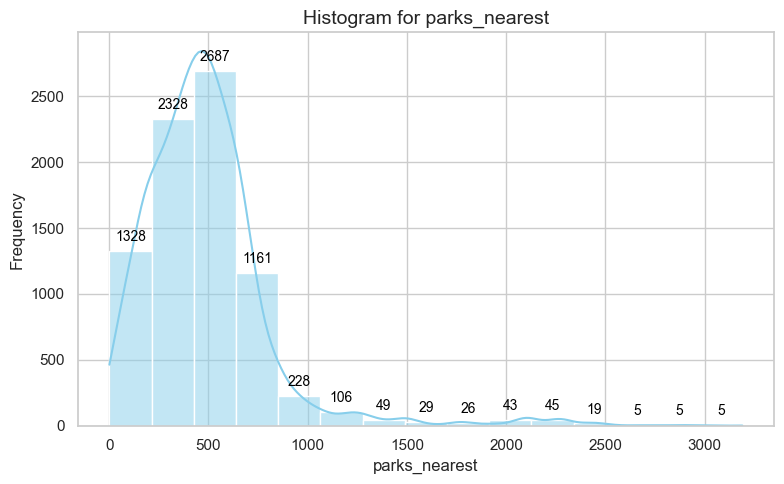

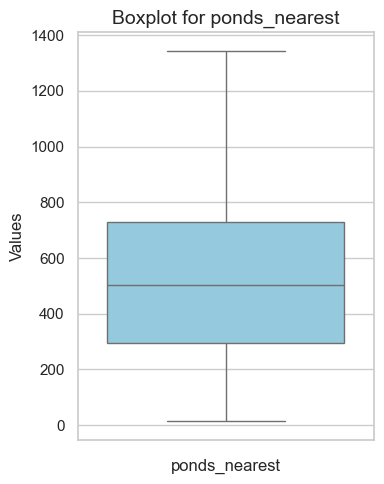

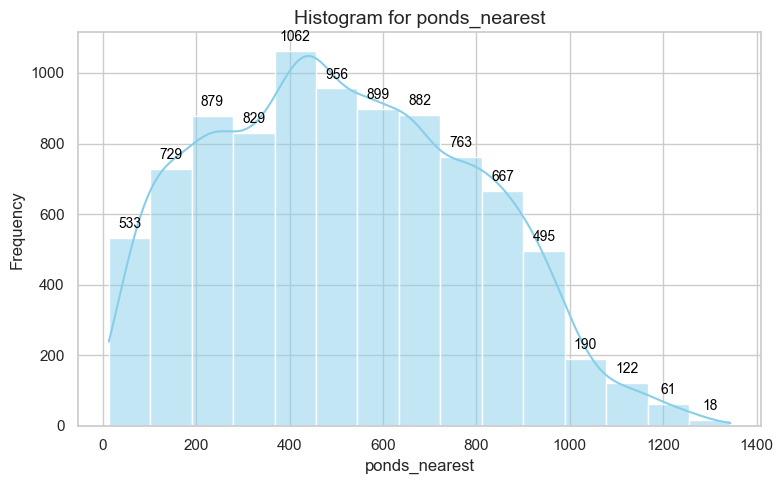

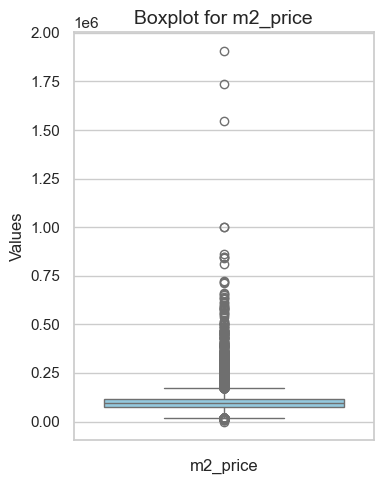

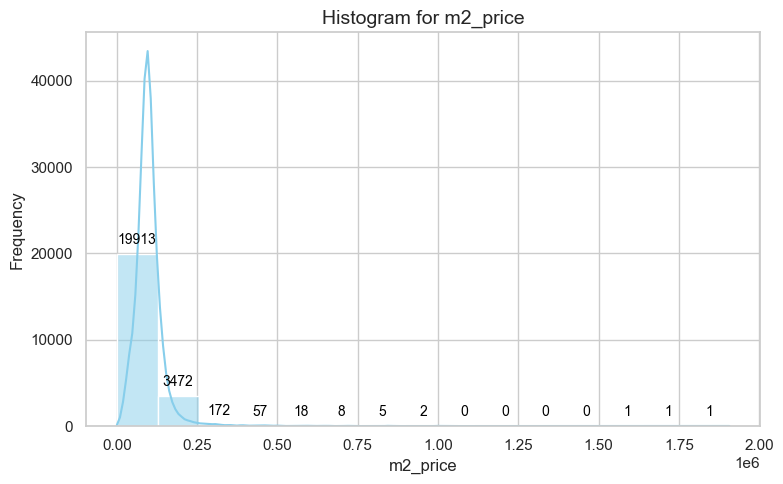

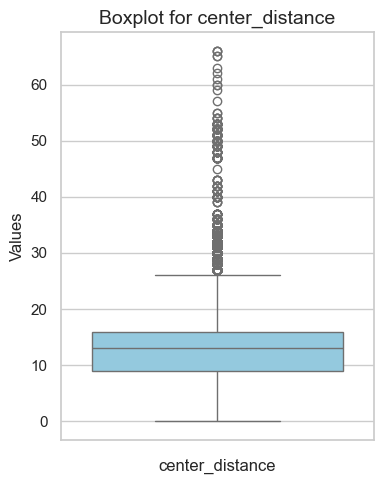

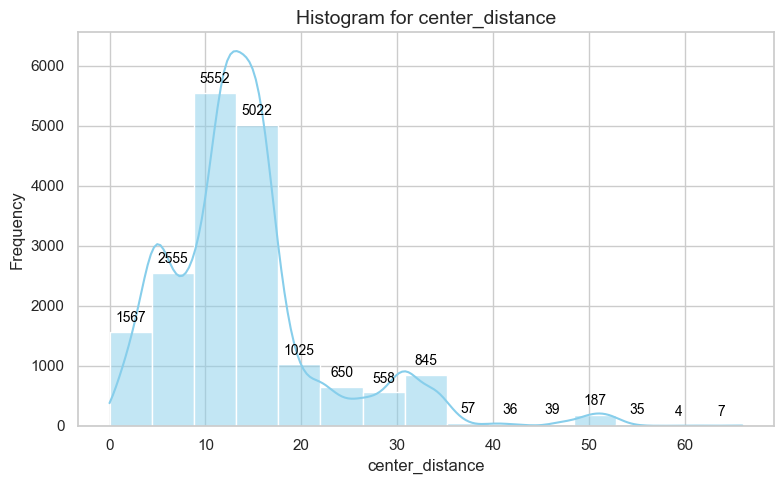

In [27]:
plot_num_data(data, num_list)

- **total_area:**
  Most values are within 100m². There are also many records for properties up to 400m². There is one value greater than 800m², which can be removed.

- **living_area:**
  Many values are up to 100m². There are a few cases exceeding 300m².

- **kitchen_area:**
  Most values are less than 30m². Values greater than 60m² can be considered anomalies.

- **last_price:**
  Most values do not exceed 100,000,000. Rare values exceed 150,000,000.

- **rooms:**
  Most properties have up to 6 rooms. There are rare anomalies with more than 10 rooms.

- **ceiling_height:**
  The minimum ceiling height is 1 meter. We'll divide values exceeding 10 meters by 10.

- **floor_category:**
  There is a roughly equal number of properties on the first and last floors. More than 17,000 properties are on other floors.

- **floors_total:**
  Most values are up to 10 floors. Values exceeding 30 floors are considered anomalies.

- **cityCenters_nearest:**
  This attribute has a wide range of values. Most values are up to 250 km. There are fewer cases beyond 250 km.

- **parks_nearest:**
  In most cases, the nearest park is within 10-15 km. Other values can be up to 32 km.

In [28]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x / 10 if x > 10 else x)

data = data.loc[(data['total_area']<800) & (data['living_area']<350) & (data['last_price']<150_000_000) &\
                (data['rooms']<15) & (data['ceiling_height']<5) & (data['floors_total']<40)]

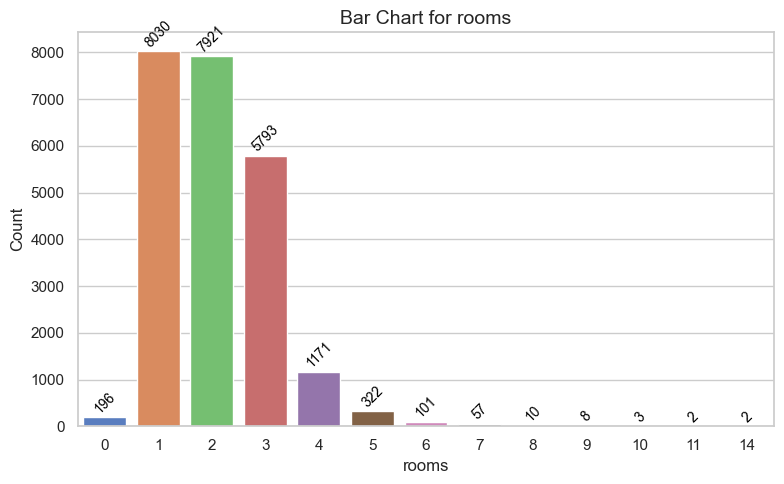

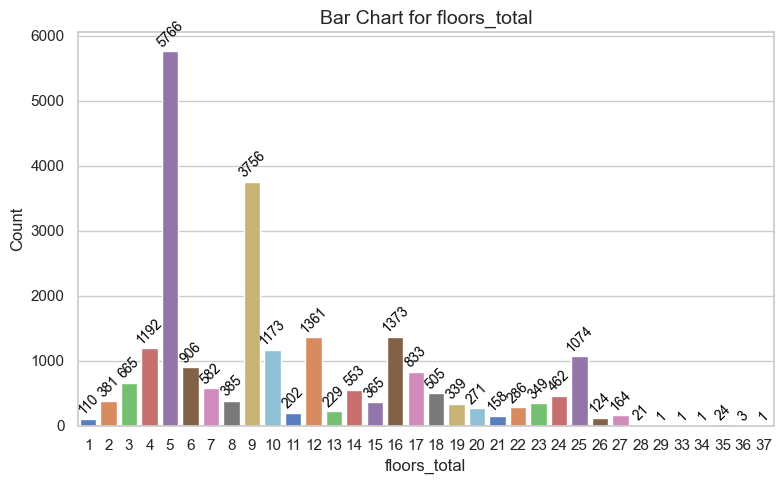

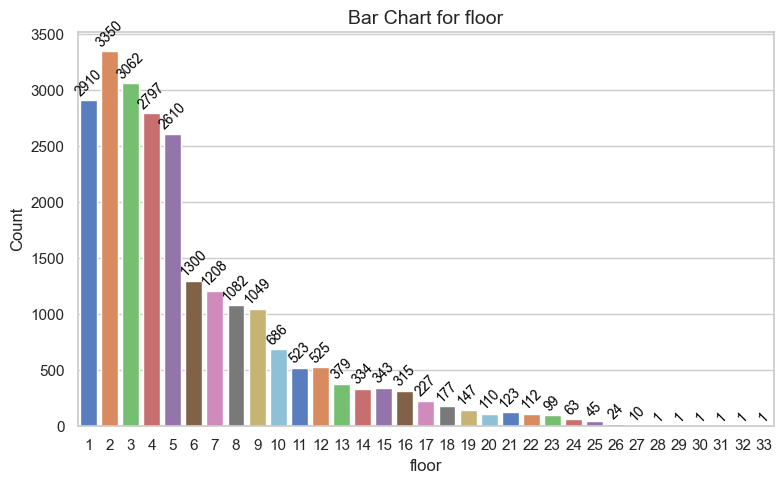

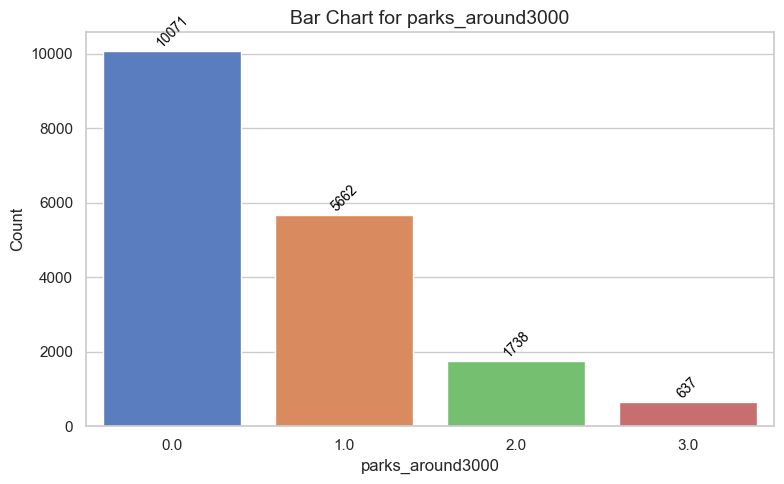

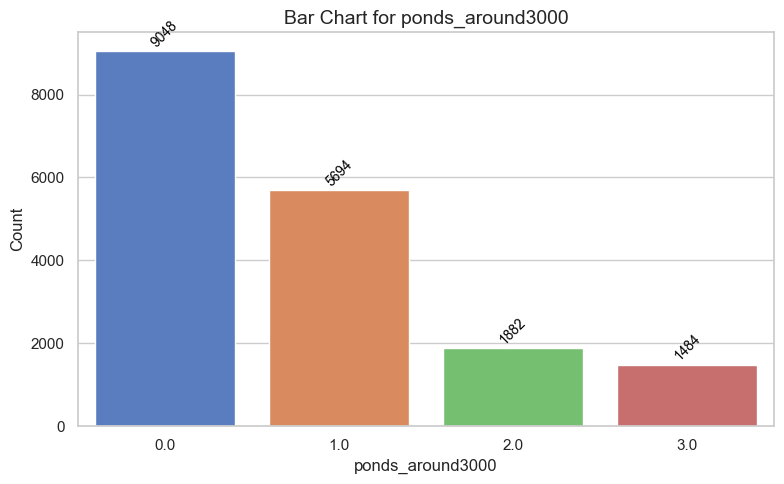

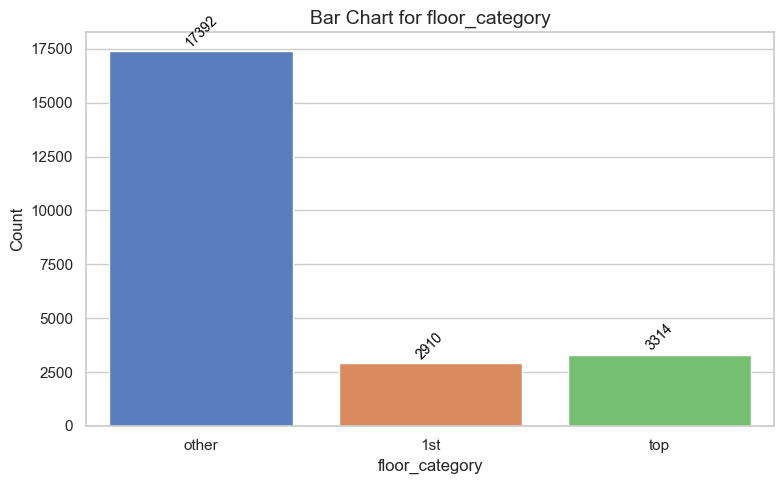

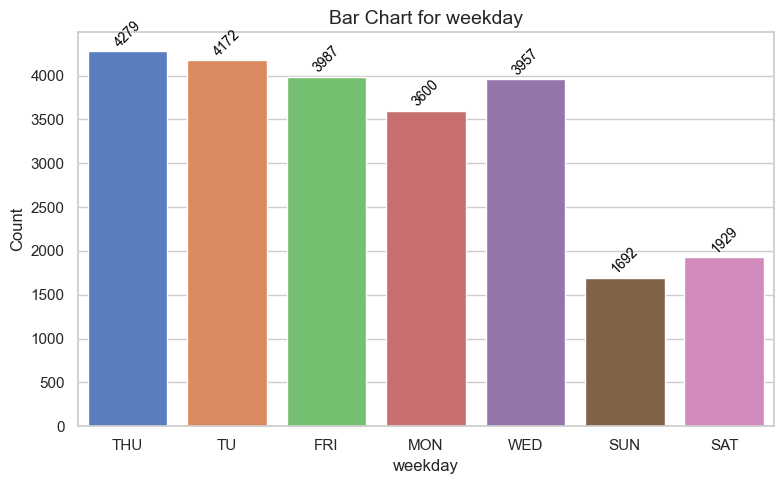

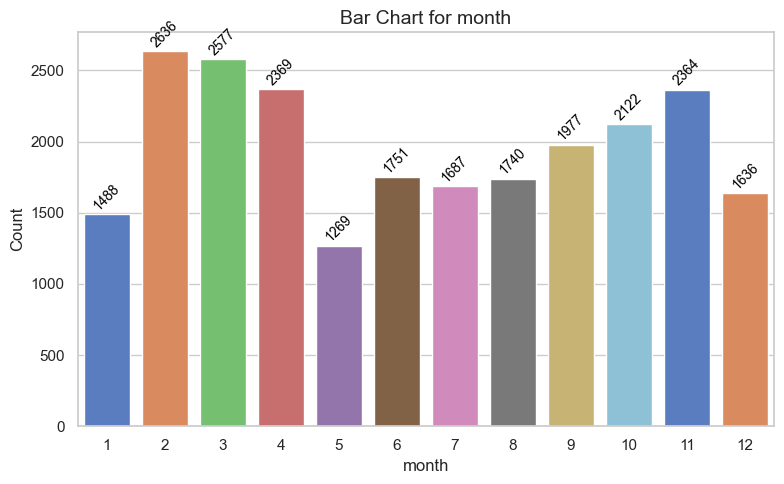

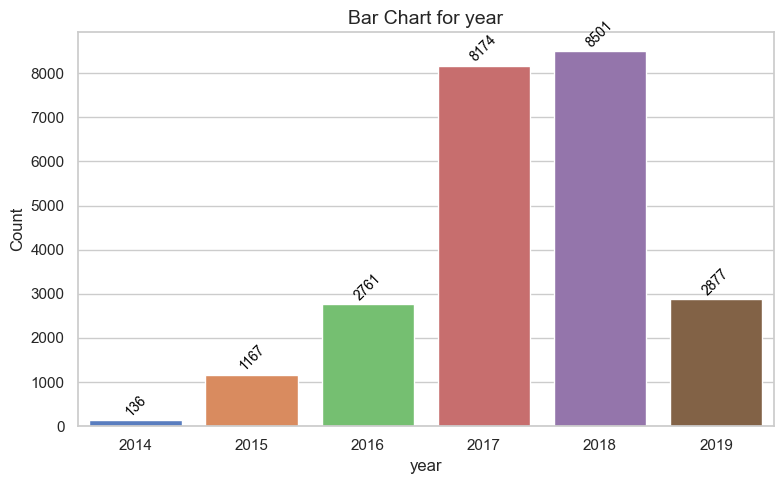

In [29]:
plot_cat_data(data, cat_list)

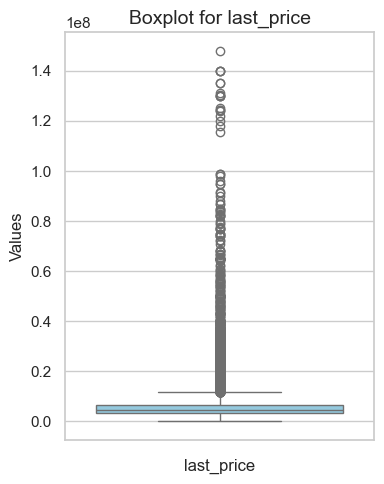

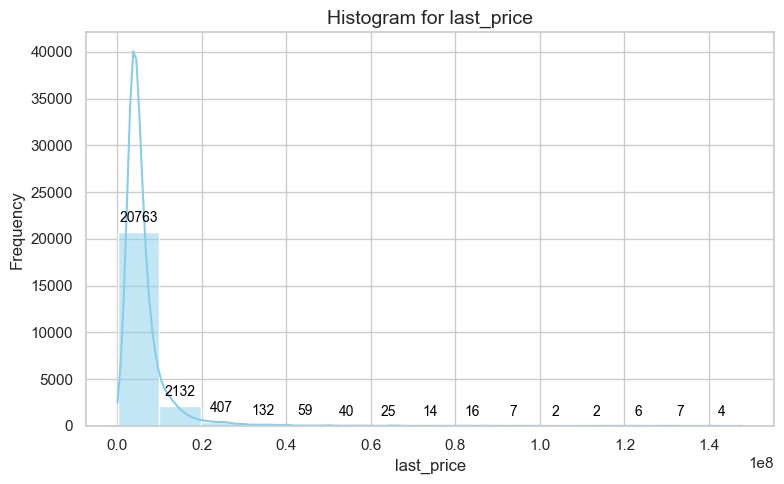

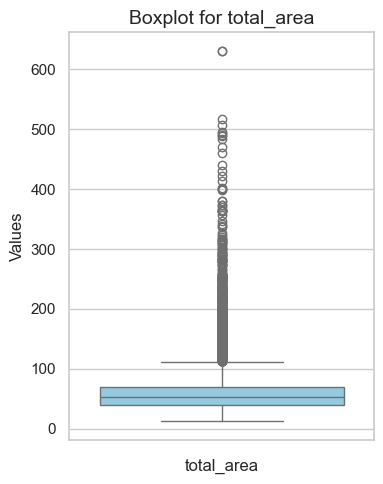

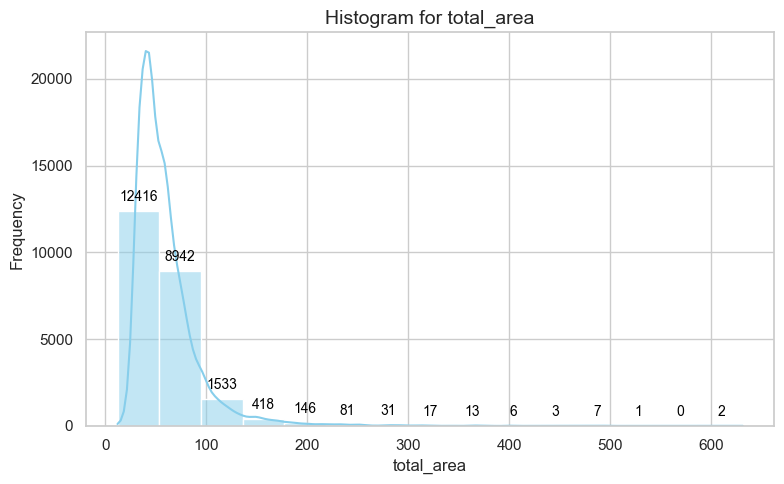

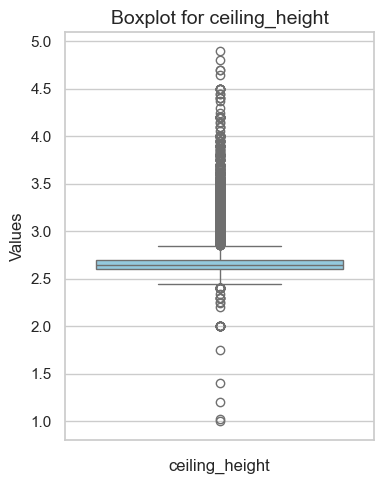

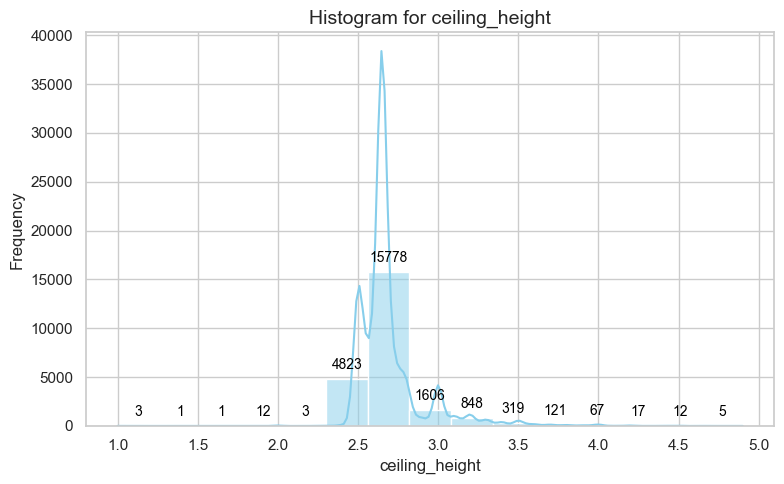

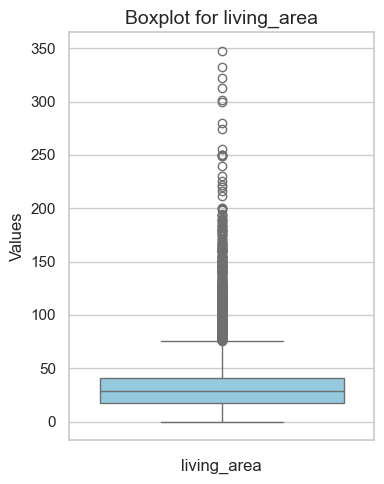

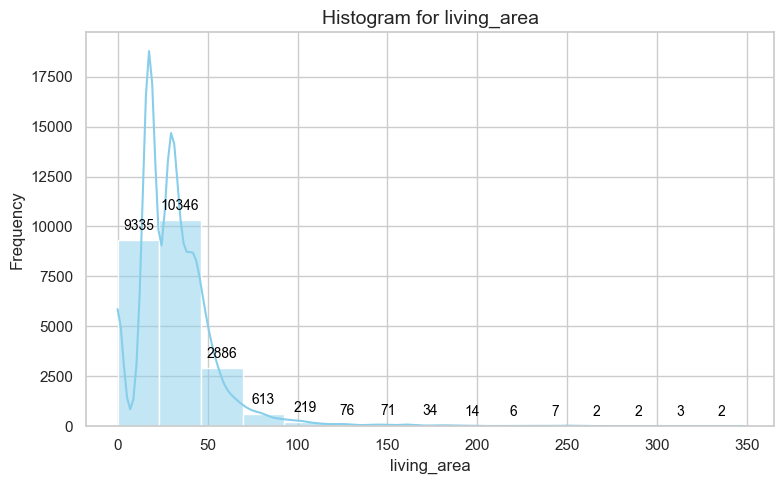

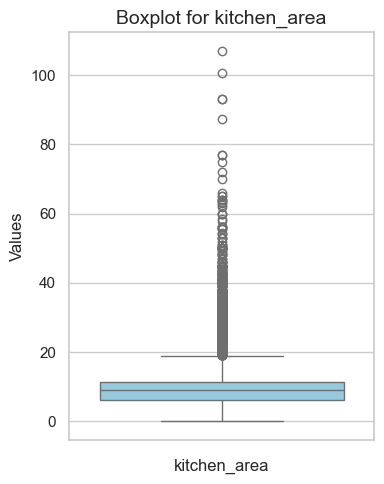

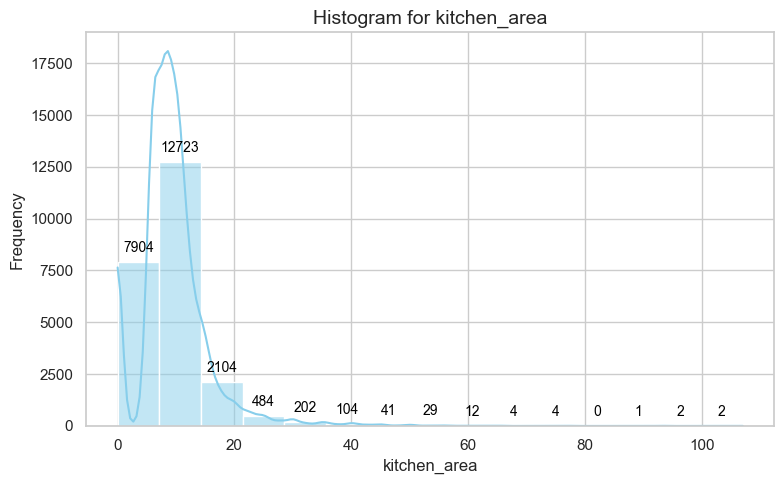

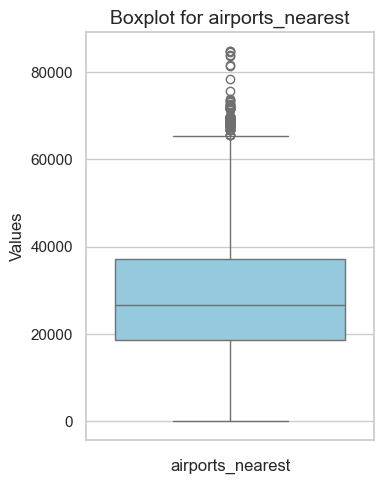

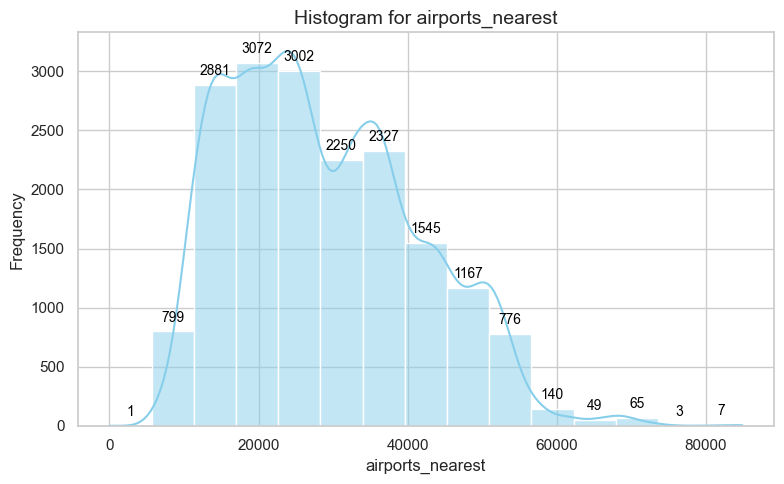

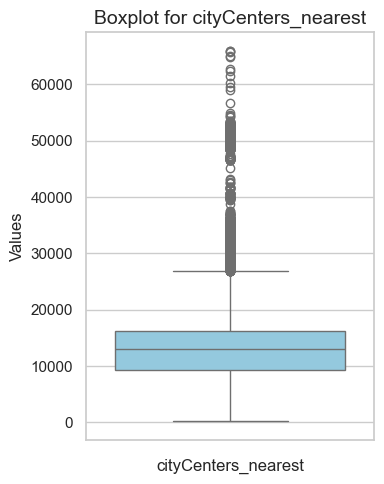

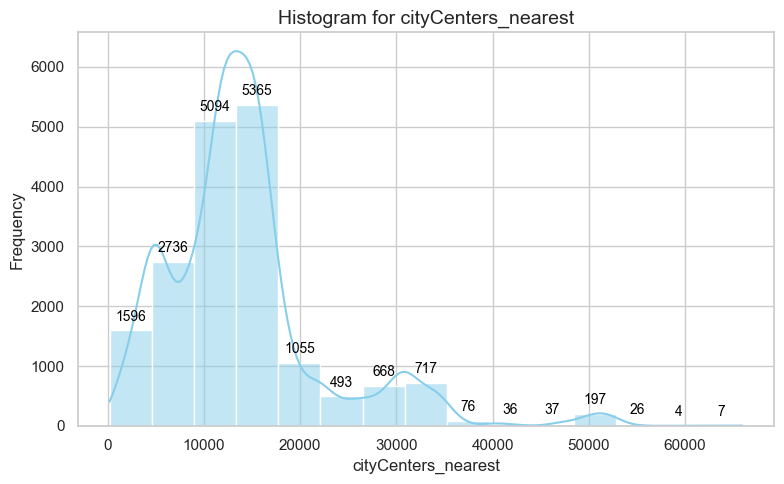

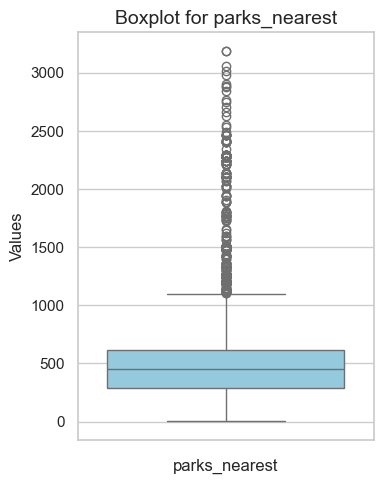

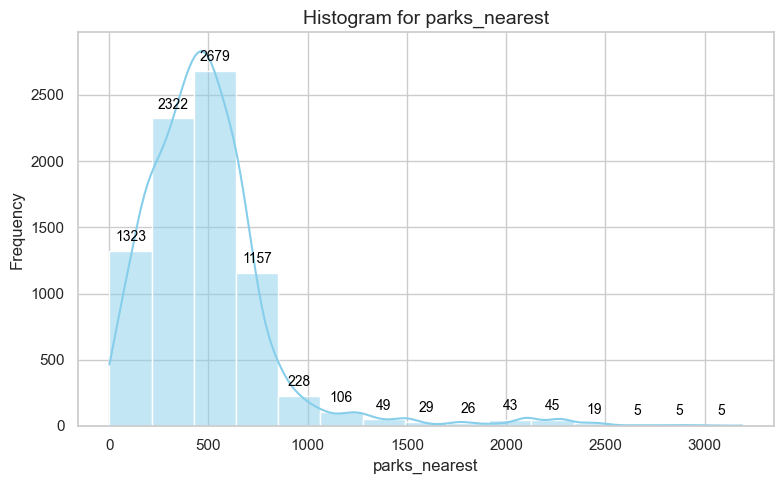

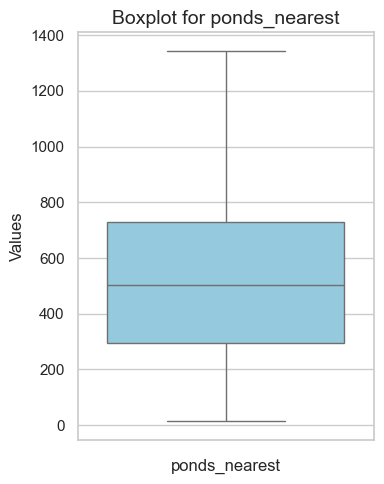

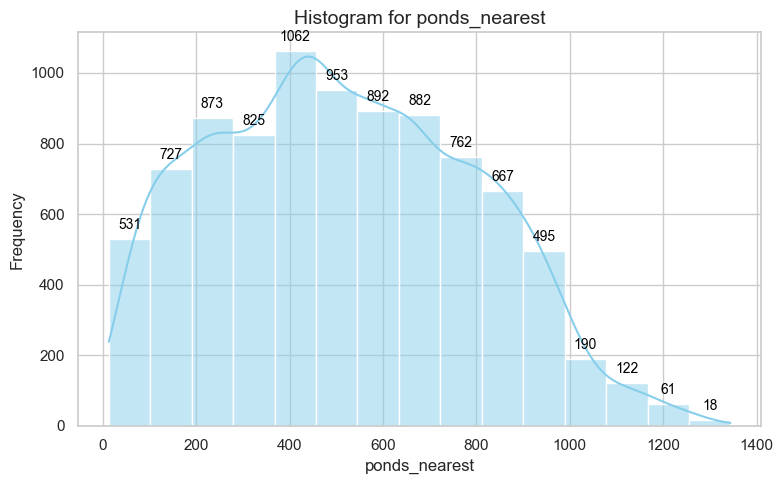

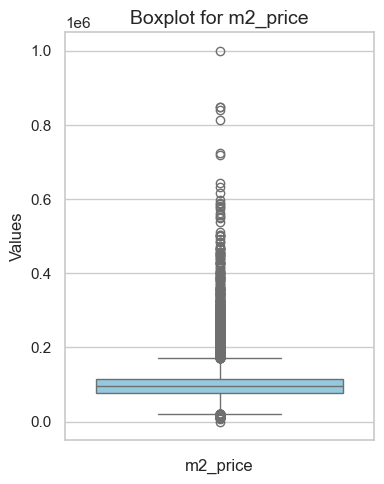

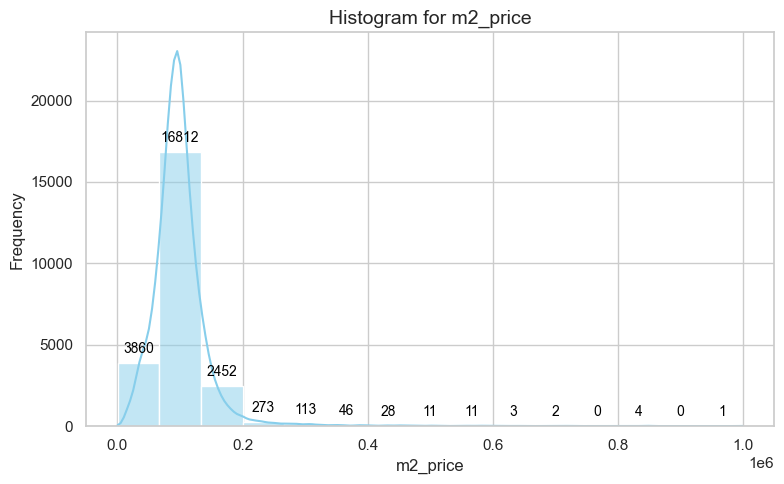

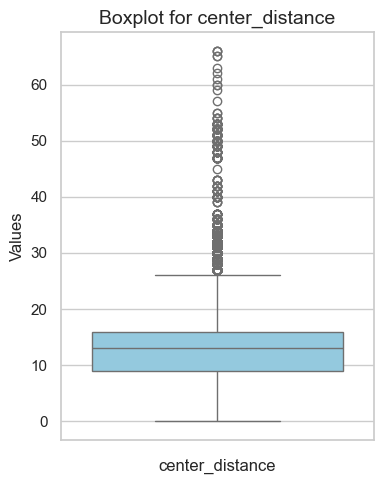

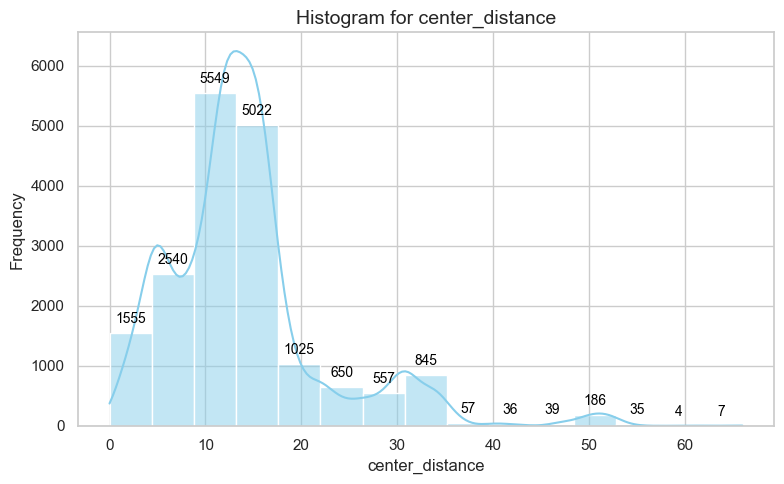

In [30]:
plot_num_data(data, num_list)

In [31]:
data.shape

(23616, 28)

### Attribute days_exposition

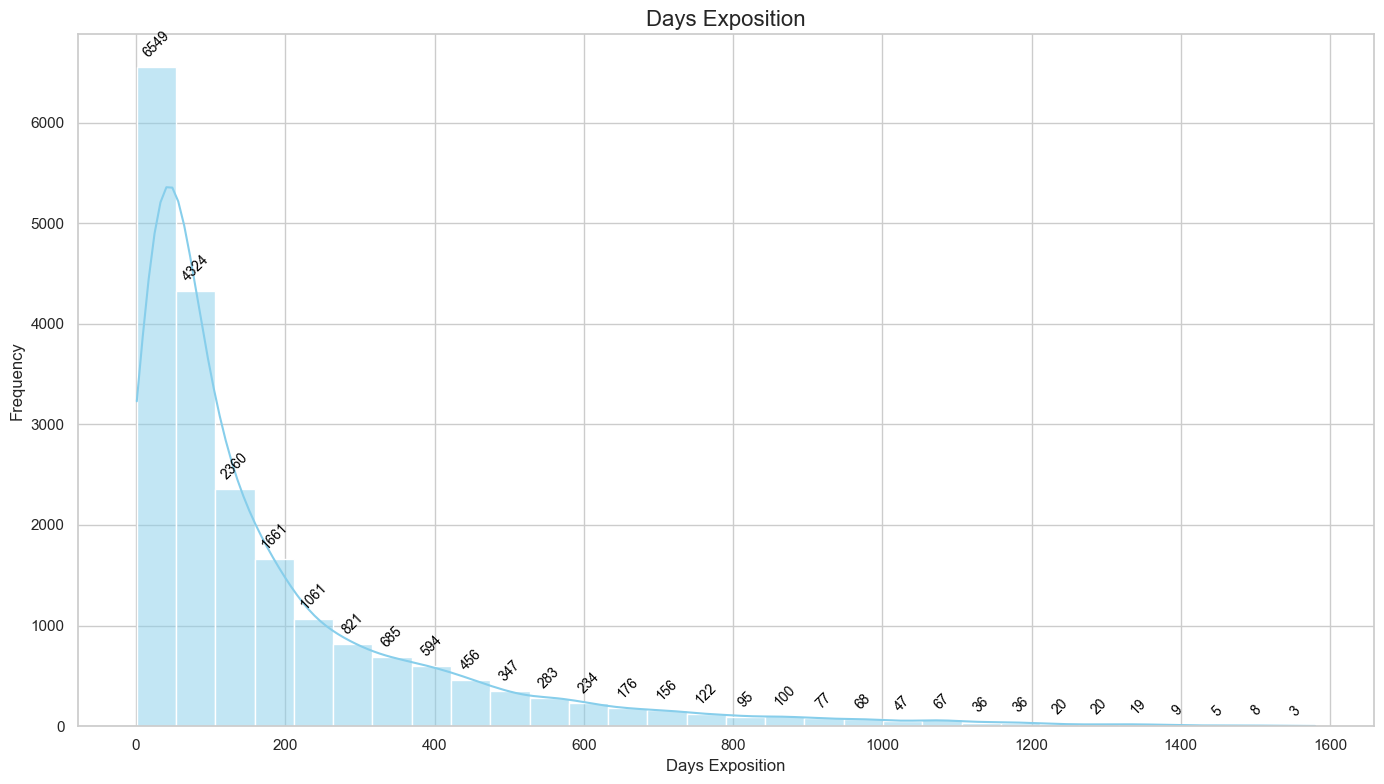

In [32]:
bins_num = 30

plt.figure(figsize=(14, 8))
ax = sns.histplot(data=data, x='days_exposition', bins=bins_num, kde=True, color='skyblue')

for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=10, color='black', rotation=45, 
                xytext=(0, 5), textcoords='offset points')

ax.set_title('Days Exposition', fontsize=16)
ax.set_xlabel('Days Exposition', fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
data['days_exposition'].describe()

count    20439.000000
mean       180.604188
std        219.564862
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

When analyzing the 'days_exposition' attribute, it is better to rely on the median value since outliers can be observed on the histogram, although most values lie in the range between 1 and 600. We assume that a quick sale falls into the first quartile, while unusually long sales fall into the fourth quartile. Therefore, less than 45 days is considered a quick sale. More than 230 days is considered a long sale.

### Attributes that have the highest impact on the price

In [34]:
columns_list = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'weekday', 'month', 'year', 'floor_category']

In [35]:
num_list = ['total_area', 'living_area', 'kitchen_area']

In [36]:
num_list_query = [[data.query('total_area > 0'), 'total_area'],
                  [data.query('living_area > 0'), 'living_area'],
                  [data.query('kitchen_area > 0'), 'kitchen_area']] 

In [37]:
def scatter_plot(df, attr):
    df.plot(x=attr, y='last_price', kind='scatter', alpha=0.3)
    plt.title("Dependency of Cost on " + attr)
    plt.show()
    print("Correlation coefficient = ", df[attr].corr(df['last_price']))

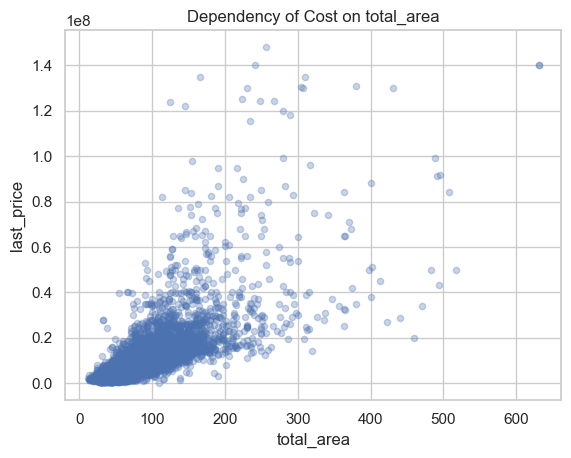

Correlation coefficient =  0.7524089728175624


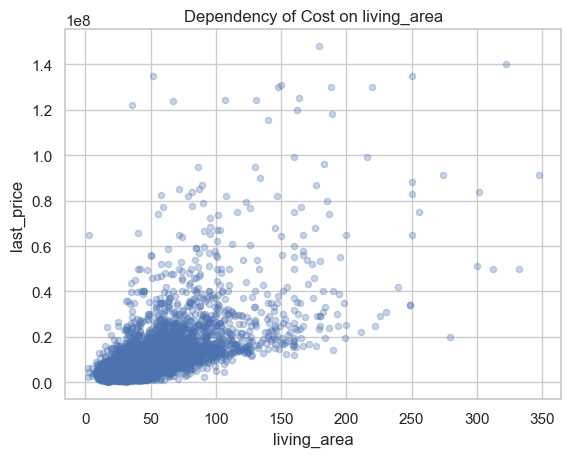

Correlation coefficient =  0.666256793500805


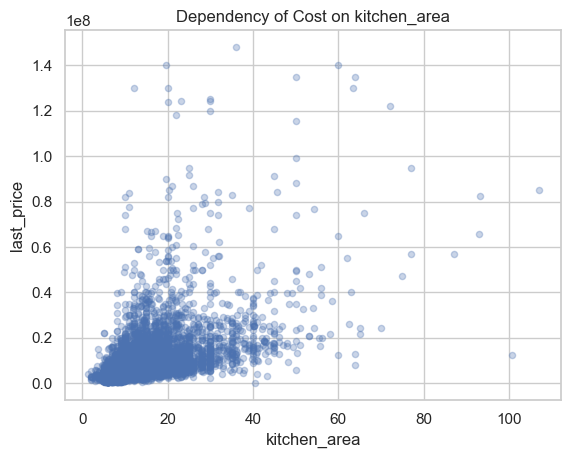

Correlation coefficient =  0.5752032874784038


In [38]:
for i in num_list_query:
    scatter_plot(i[0], i[1])

For these three parameters, a similar dependency can be observed. There is a concentration of values in specific areas. It can be said that the dependency on total_area and living_area is stronger than on kitchen_area. This conclusion is also supported by the correlation coefficient values. However, for none of the attributes can we definitively state that there is a direct dependency, as there are a large number of data points outside the concentrated areas where examples of inverse dependencies can also be found.

In [39]:
category_list = ['rooms', 'weekday', 'month', 'year', 'floor_category']

In [40]:
def pivot(data, index):
    pivot = data.pivot_table(index=index, values='last_price', aggfunc=['count', 'mean']).reset_index()
    pivot.columns = [index, 'count', 'mean price']
    
    display(pivot.sort_values(by='mean price', ascending=True))
    
    plt.figure(figsize=(7, 4))
    
    sns.barplot(x=index, y='mean price', hue=index, data=pivot, palette='viridis', dodge=False, legend=False)
    
    plt.title(f'Mean Price by {index}')
    plt.xlabel(index)
    plt.ylabel('Mean Price')
    plt.xticks(rotation=45)
    plt.show()

,rooms,count,mean price
0,0,196,3.312917e+06
1,1,8030,3.833149e+06
2,2,7921,5.555074e+06
3,3,5793,8.090007e+06
4,4,1171,1.297561e+07
5,5,322,2.164701e+07
6,6,101,2.522726e+07
11,11,2,2.525000e+07
10,10,3,2.616667e+07
12,14,2,2.682950e+07


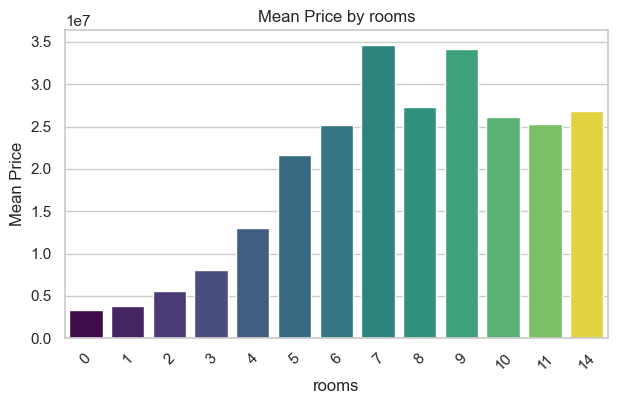

,weekday,count,mean price
3,SUN,1692,6.249360e+06
6,WED,3957,6.252190e+06
2,SAT,1929,6.252277e+06
0,FRI,3987,6.282025e+06
1,MON,3600,6.283756e+06
5,TU,4172,6.289658e+06
4,THU,4279,6.643802e+06


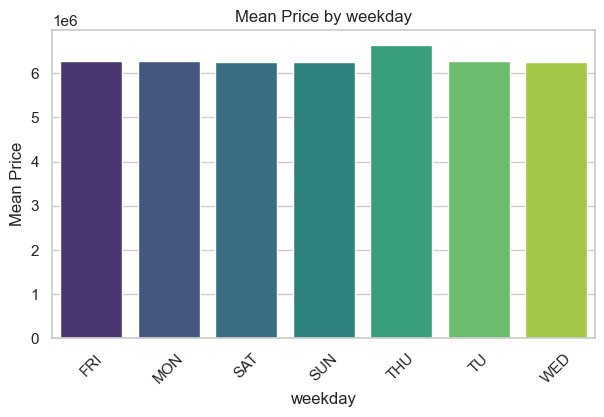

,month,count,mean price
9,10,2122,6.097310e+06
2,3,2577,6.175844e+06
5,6,1751,6.263939e+06
7,8,1740,6.264950e+06
1,2,2636,6.294715e+06
3,4,2369,6.342912e+06
10,11,2364,6.383533e+06
0,1,1488,6.418454e+06
4,5,1269,6.418729e+06
8,9,1977,6.447428e+06


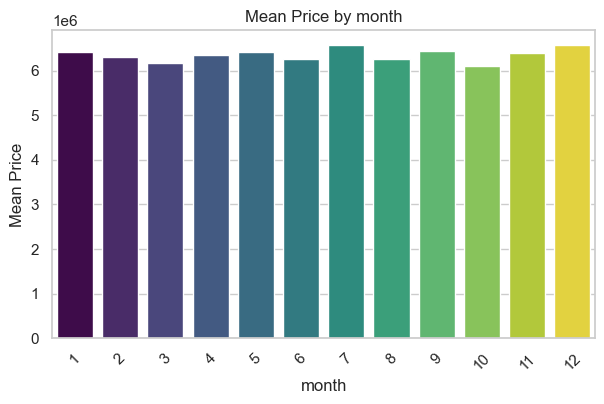

,year,count,mean price
4,2018,8501,5.876219e+06
3,2017,8174,6.267770e+06
2,2016,2761,6.568476e+06
5,2019,2877,6.663976e+06
1,2015,1167,8.208281e+06
0,2014,136,1.204660e+07


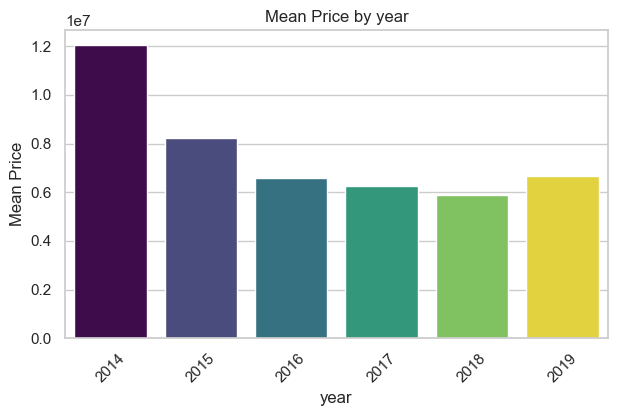

,floor_category,count,mean price
0,1st,2910,4.801651e+06
2,top,3314,6.468012e+06
1,other,17392,6.572212e+06


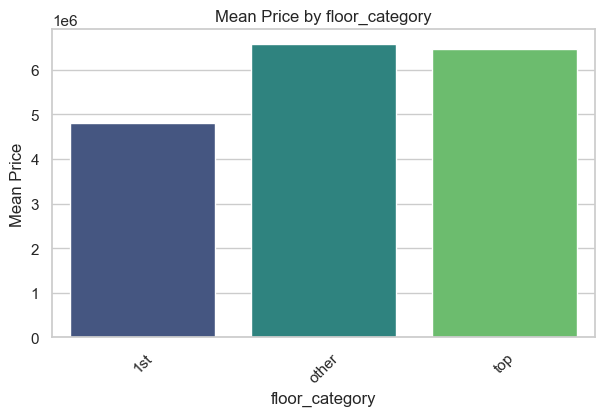

In [41]:
for i in category_list:
    pivot(data, i)

- **rooms:**
  Not all categories have the same amount of data, but nevertheless, it can be observed that as the number of rooms increases, the price correspondingly increases. There is an exception for categories with 0 and 1 room. This may be due to the type of property. The price for one-room residential apartments may be lower than for non-residential properties. This can also be explained by the varying amount of data. There are only 28 records for properties with 0 rooms, which is much fewer than the number of one- and two-room apartments.

- **weekday:**
  The highest prices are for properties listed on Thursday. Lower prices are observed for listings on Sunday and Thursday. It is unlikely that a clear dependency can be identified or explained for this attribute.

- **month:**
  The data for this attribute is fairly evenly distributed, but no clear dependency can be identified either by individual months or by seasons. The highest prices are for properties listed in December, September, and July. This may be related to the start of the academic and calendar year.

- **year:**
  The price for relatively new properties (2016-2019) is lower than for properties listed earlier (2014-2015). A dependency can be noted between these two categories but not for individual years.

- **floor_category:**
  Since we do not have data on the floors in the "other" category, it cannot be definitively stated that the higher the floor, the higher the price. Nevertheless, properties on the first floors are the least expensive.

#### Neighbourhoods by price

In [42]:
pivot_locality = data.pivot_table(index = 'locality_name', values = 'm2_price', aggfunc = ['count', 'mean']).reset_index()
pivot_locality.columns = ['locality_name', 'count', 'mean_price']

In [43]:
top_10 = pivot_locality.sort_values(by='count', ascending=False).head(10).reset_index()
top_10

,index,locality_name,count,mean_price
0,33,Санкт-Петербург,15691,114525.822422
1,229,поселок Мурино,556,86312.033129
2,304,поселок Шушары,440,79068.603091
3,3,Всеволожск,398,68985.235553
4,32,Пушкин,369,103611.362954
5,13,Колпино,338,75735.589882
6,239,поселок Парголово,327,90675.627492
7,6,Гатчина,307,69045.518925
8,92,деревня Кудрово,299,93002.173411
9,4,Выборг,237,58296.119536


In [44]:
top_10.sort_values(by='mean_price')

,index,locality_name,count,mean_price
9,4,Выборг,237,58296.119536
3,3,Всеволожск,398,68985.235553
7,6,Гатчина,307,69045.518925
5,13,Колпино,338,75735.589882
2,304,поселок Шушары,440,79068.603091
1,229,поселок Мурино,556,86312.033129
6,239,поселок Парголово,327,90675.627492
8,92,деревня Кудрово,299,93002.173411
4,32,Пушкин,369,103611.362954
0,33,Санкт-Петербург,15691,114525.822422


St. Petersburg has the highest number of listings. It also has the highest price per square meter among the localities with the most listings.
The lowest price among the localities with a large number of listings is in Vyborg.

#### Dependency of Cost on Distance to the City Center

In [45]:
pivot_distance = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='center_distance', values = 'm2_price', aggfunc = ['count', 'mean']).reset_index()
pivot_distance.columns = ['center_distance', 'count', 'mean price']
pivot_distance = pivot_distance.query('count > 5')
pivot_distance

,center_distance,count,mean price
0,0.0,26,232379.554231
1,1.0,188,159525.961011
2,2.0,308,153857.849221
3,3.0,350,121744.829657
4,4.0,683,130752.158009
5,5.0,914,138758.540317
6,6.0,613,148295.481876
7,7.0,418,156550.292967
8,8.0,595,124802.111092
9,9.0,593,113607.754975


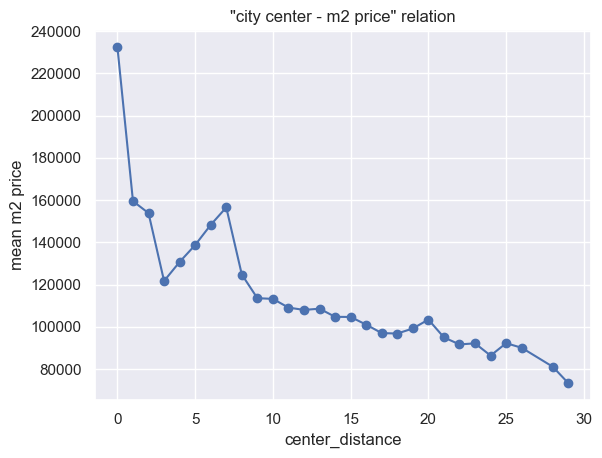

In [46]:
plt.plot(pivot_distance['center_distance'], pivot_distance['mean price'], marker='o', linestyle='-')
plt.xlabel('center_distance')
plt.ylabel('mean m2 price')
plt.title('"city center - m2 price" relation')
plt.grid(True)
plt.show()

There are a total of 30 categories. Apartments in the city center are the most expensive. The price decreases up to a distance of 3 km, and then it rises again. It is possible that there are elite neighborhoods within 3-7 km from the center. After 7 km, the price decreases with occasional exceptions.

## Summary

Several stages were completed during the project. First, the values of individual attributes were analyzed. This included the distribution of values by categories, filling in missing values, converting values to the correct data types, and removing duplicates.

To accurately analyze the dependency of price on various attributes, rare values were removed, and anomalous values were transformed.

Attributes were divided into numerical and categorical, and separate analyses were conducted with different functions written for plotting graphs. In the graphs for numerical attributes, it is possible to trace the dependency of price increase with the increase in kitchen area, living area, and total area of the property. However, there are outliers in these dependencies.

For categorical variables, pivot tables were created. It can be concluded that the price increases with the number of rooms. The highest prices are for apartments on the top floors, listed in September and December, and in the period of 2014-2015.

Location also influences the price. Apartments with the highest price per square meter are located in St. Petersburg at a distance of 0-3 and 6-7 km from the center.

Overall, it is necessary to analyze the existing attributes in combination to identify the pattern of price increase. The dependency on individual attributes is not always clear and straightforward.